# Vorhersage von Produkterfolg auf kickstarter



In [1]:
#!pip install shap
#anschließend Kernel neustarten und diese Zeile auskommentieren
#

In [2]:
# alle notwendigen Pakete werden geladen
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm
import shap

In [3]:
# Einlesen der Daten
kickstarter = pd.read_csv("kickstarter_data.csv")

In [4]:
# Anzeigen der ersten Zeilen des Datensatzes
kickstarter.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US


In [5]:
#Anzeigen der Spaltennamen des Datensatzes
kickstarter.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country'],
      dtype='object')

In [6]:
# wie häufig kommen die einzelnen Einträge aus State im Datensatz vor?
kickstarter.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

### die interessanten Einträge aus State sind failed und successful \- alle anderen werden nicht mehr betrachtet



In [7]:
# behalte im Datensatz kickstarter nur die Einträge die entweder failed oder successful sind
kickstarter = kickstarter[(kickstarter.state=='failed')|(kickstarter.state=='successful')]

In [8]:
# wie häufig kommen NUN die einzelnen Einträge aus State im Datensatz vor?
kickstarter.state.value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [9]:
# ersetze in der Spalte State den Eintrag failed mit 0 und sucessful mit 1
kickstarter["state"] = kickstarter["state"].replace({"failed": 0, "successful": 1})

In [10]:
# zeige die Form des Datensatzes: wie viele Zeilen und Spalten beinhaltet der Datensatz?
kickstarter.shape

(331675, 12)

## erstes Machine Learning Modell 

In [11]:
# definiere neuen Datensatz kickstarter_first, beinhaltet alle Spalten bis auf ID, name, pledged sum:
kickstarter_first = kickstarter[
    [
        "category",
        "main_category",
        "currency",
        "deadline",
        "goal",
        "launched",
        "backers",
        "country",
        "state"

    ]
] 

In [12]:
# wir teilen nun den Datensatz, um das Machine Learning vorzubereiten
# X beinhaltet alle Spalten die als potentielle Einflussfaktoren verwendet werden können.
# Das sind aus dem kickstarter_first Datensatz alle Spalten bis auf die letzte.
X = kickstarter_first[kickstarter_first.columns[:-1]].copy()

In [13]:
# y beinhaltet die Zielvariable, die vorhergesagt werden soll. 
# Hier also State. Das ist im kicktstarter_first Datensatz die letzte Spalte. 
y = kickstarter_first[kickstarter_first.columns[-1:]].copy()

In [14]:
# LightGBM kann sehr gut mit Kategorien umgehen. Wir setzen deshalb alle Spalten, 
# deren Einträge als object verarbeitet werden als kategorielle Features
categorical_features_indices = np.where(X.dtypes == object)[0]

In [15]:
X.iloc[:,categorical_features_indices]=X.iloc[:,categorical_features_indices].astype('category')

In [16]:
# Anschauen welche verschiedenen Arten von Daten in X sind
# integer = ganze Zahlen
# float = Gleitkommazahlen
# object = Eintrag wird nicht verarbeitet, bleibt so wie es ist (in unserem Fall Text)
X.dtypes

category         category
main_category    category
currency         category
deadline         category
goal              float64
launched         category
backers             int64
country          category
dtype: object

In [17]:
# teile X und y in X_train, X_test, y_train und y_test
# 10% des Datensatzes werden zu Test, 90% bleiben in Train und bilden damit die Grundlage fürs Machine Learning
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# train model

In [18]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(np.equal(y_true, np.round(y_pred))) / len(y_true)
    return "accuracy", accuracy, False

In [23]:
# Model wird initialisiert: wir nutzen als Algorithmus LightGbm
# Randomisierung wird auf einen festen Wert gesetzt, damit wir bei jedem Durchgang dieselben Werte rauskriegen
# die Güte des Modells wird mit Accuracy festgestellt
model = lightgbm.LGBMClassifier(random_state=42, metric="accuracy",n_estimators=200)

In [24]:
# unsere Maschine lernt
# das Modell wird gefittet. Die Grundlage für das Lernen sind X_train und y_train, 
# kategorielle Features werden festgelegt, als Evaluation dienen X_test und y_test
# ravel ist eine Konvention von LightGBM (es wird bestimmte Form der Daten erwartet, ravel passt die Daten daran an)
model.fit(
    X_train, y_train.values.ravel(),
    eval_set=[(X_test, y_test.values.ravel())],
    eval_metric=accuracy)# je höher accuracy desto besser

[1]	valid_0's accuracy: 0.595363
[2]	valid_0's accuracy: 0.861222
[3]	valid_0's accuracy: 0.912717
[4]	valid_0's accuracy: 0.919953
[5]	valid_0's accuracy: 0.923722
[6]	valid_0's accuracy: 0.924958
[7]	valid_0's accuracy: 0.926013
[8]	valid_0's accuracy: 0.926164
[9]	valid_0's accuracy: 0.926194
[10]	valid_0's accuracy: 0.926827
[11]	valid_0's accuracy: 0.92737
[12]	valid_0's accuracy: 0.927912
[13]	valid_0's accuracy: 0.928877
[14]	valid_0's accuracy: 0.929088
[15]	valid_0's accuracy: 0.92948
[16]	valid_0's accuracy: 0.929812
[17]	valid_0's accuracy: 0.929812
[18]	valid_0's accuracy: 0.930204
[19]	valid_0's accuracy: 0.930415
[20]	valid_0's accuracy: 0.930867
[21]	valid_0's accuracy: 0.931862
[22]	valid_0's accuracy: 0.932013
[23]	valid_0's accuracy: 0.932073
[24]	valid_0's accuracy: 0.931983
[25]	valid_0's accuracy: 0.932344
[26]	valid_0's accuracy: 0.932164
[27]	valid_0's accuracy: 0.931952
[28]	valid_0's accuracy: 0.932164
[29]	valid_0's accuracy: 0.932133
[30]	valid_0's accuracy: 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='accuracy', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [25]:
# der Model Score sagt uns wie gut unsere Vorhersagen sind. 1 ist perfekt
# hier wird (voreingestellt) Accuracy verwendet
model.score(X_test, y_test)  

0.9320429329474192

In [26]:
# die Vorhersagen, die auf der Basis von X_test gebildet werden, werden unter predictions gespeichert
predictions = model.predict(X_test)

In [27]:
# Funktion, um Konfusionsmatrix zu erstellen
def eval_crosstab(predictions, y_test=np.concatenate(y_test.values)):
    return pd.crosstab(
        index=y_test, columns=predictions, rownames=["reality"], colnames=["prediction"]
    )

In [28]:
# Funktion auf die predictions anwenden
# Anschließend crosstab anzeigen
crosstab = eval_crosstab(predictions)
crosstab

prediction,0,1
reality,,
0,18508,1239
1,1015,12406


## Erklärbarkeit

In [29]:
# Feststellen der Wichtigkeit der einzelnen Einflussfaktoren (Spalten) auf die Vorhersage
# Explainer baut die Interpretationsmethoden für dieses Modell auf
explainer = shap.TreeExplainer(model)
# Shap gibt in der Standardeinstellung Multiklassen raus. 
# Wir nehmen hier die shap values ist unsere target Variable 1 geworden, also war das Kickstarter Projekt erfolgreich
shap_values= explainer.shap_values(X_test)[1]
# Mittelwert aller Vorhersagen. Zeigt später in der Visualisierung den Start der Gewichte an.
expected_value = explainer.expected_value[0]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


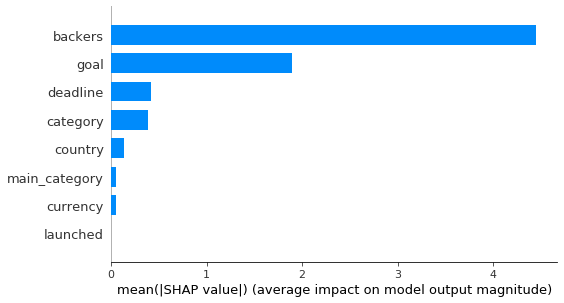

In [30]:
# Anzeigen der Feature Importances 
shap.summary_plot(shap_values, X_test, plot_type = "bar")